This notebook references the following tutorials:

* inferring in DV mode with spatial regularization
* inferring in stochastic DV mode with temporal regularization
* calculating Bayes factors on the forces inferred in DD mode
* adjusting the mesh for Bayes factor calculation

### Note:
The examples below call the low-level API and will be updated so that the higher-level `RWAnalyzer` API is called instead.

# Inferring in DV mode with spatial regularization

/home/flaurent/github/RWA-python/rwa/hdf5.py:185: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel # Panel has been flagged deprecated


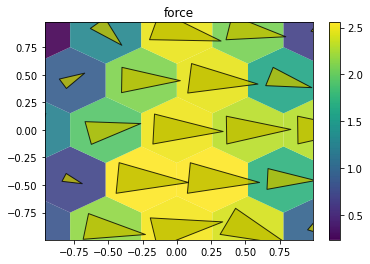

In [1]:

## key parameters
# smoothing parameters
diffusivity_smoothing = potential_smoothing = 1.
# localization error in um
localization_precision = 0.01

## import
%matplotlib inline
from tramway.helper.inference import *
from tutorial import load_default_partition

## load the partition
cells = load_default_partition()

## infer
maps = infer(cells, 'DV',
        diffusivity_prior=diffusivity_smoothing, potential_prior=potential_smoothing,
        sigma=localization_precision)

## plot the force
_=map_plot(maps, cells=cells, title='force', feature='force', cell_arrow_ratio=1)
# other features are 'diffusivity' and 'potential'


# Inferring in stochastic DV mode with temporal regularization

You can interrupt the kernel (or hit Ctrl+C if not in a notebook) to stop the inference before convergence; maps will be generated anyway

segment: 0


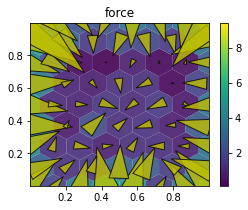

segment: 1


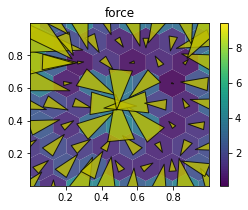

segment: 2


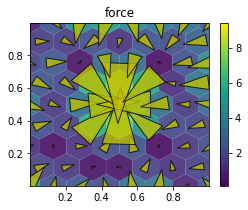

segment: 3


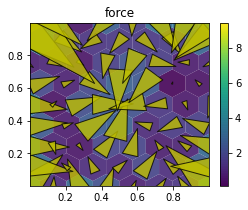

segment: 4


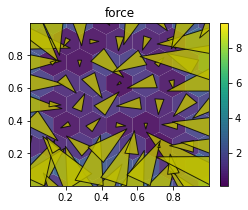

In [2]:

## key parameters
# spatial smoothing parameters
diffusivity_smoothing = potential_smoothing = 1.
# temporal smoothing parameter
time_smoothing = 1.
# localization error in um
localization_precision = 0.01

## import
%matplotlib inline
from tramway.helper.inference import *
from tramway.inference.time import *
from tutorial import load_default_partition

## load the partition
cells = load_default_partition(time_varying_properties=True)

## infer
maps = infer(cells, 'stochastic.dv',
        diffusivity_prior=diffusivity_smoothing,
        potential_prior=potential_smoothing,
        time_prior=time_smoothing,
        sigma=localization_precision)

## plot the force
number_of_segments = len(cells.tessellation.time_lattice)
for segment in range(number_of_segments):
    
    print('segment: {}'.format(segment))
    map_plot(maps, cells, segment=segment, show=True, title='force', figsize=(4,3), feature='force')
    # other features are 'diffusivity' and 'potential'


# Calculating Bayes factors on the inferred forces

/home/flaurent/github/TRamWAy/tramway/inference/bayes_factors/group_by_sign.py:73: RuntimeWarning: invalid value encountered in greater_equal
  group_forces = 1 * (group_lg_B >= np.log10(B_threshold)) - \
/home/flaurent/github/TRamWAy/tramway/inference/bayes_factors/group_by_sign.py:74: RuntimeWarning: invalid value encountered in less_equal
  1 * (group_lg_B <= -np.log10(B_threshold))


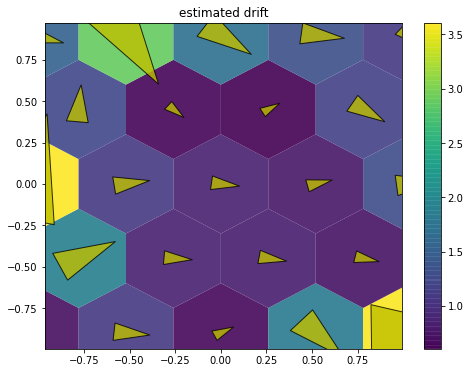

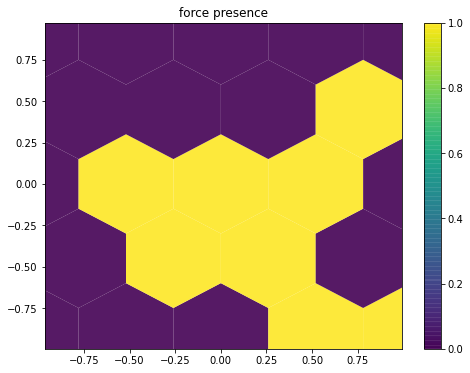

In [3]:

## key parameters
# localization error in um
localization_precision = 0.01

# labels
partition_label = 'default' # do NOT modify
model_label = 'DD mode' # can be any integer or string value
bayes_factor_label = 'Bayes factors' # idem

## import
%matplotlib inline
from tramway.helper import *
from tutorial import load_default_tree

## load the analysis tree
analyses = load_default_tree()
# the structure is:
# --> default trajectories
#  +--> default partition
#    +--> (possibly) default maps

## infer
# DD mode
infer(analyses, 'degraded.ddrift', sigma=localization_precision,
     input_label=partition_label, output_label=model_label)
# the structure now is:
# --> default trajectories
#  +--> default partition
#    +...
#    +--> DD-mode maps

# add SNR extensions required by the bayes_factor plugin
infer(analyses, 'snr', input_label=(partition_label, model_label), inplace=True)
# (the tree structure has not moved)

# Bayes factors
infer(analyses, 'bayes_factor', sigma=localization_precision,
     input_label=(partition_label, model_label), output_label=bayes_factor_label)
# the structure now is:
# --> default trajectories
#  +--> default partition
#    +...
#    +--> DD+SNR maps
#      +--> Bayes factor maps

## plot the force detection map
figsize = (8,6)
map_plot(analyses, label=(partition_label, model_label), title='estimated drift', feature='drift', cell_arrow_ratio=1, figsize=figsize, show=True)
map_plot(analyses, label=(partition_label, model_label, bayes_factor_label), title='force presence', feature='force', figsize=figsize, show=True)



    1= force; 0= not enough evidence; -1= no force
    

# Adjusting the mesh for Bayes factor calculation

This notebook cell follows and requires the previous one.

The (naive) approach here consists of considering more locations per cell (or bin)
sampling as many nearest-neighbour locations as desired.

Minimum number of locations required to define whether
there is a force or not (as long as the variance does not change):

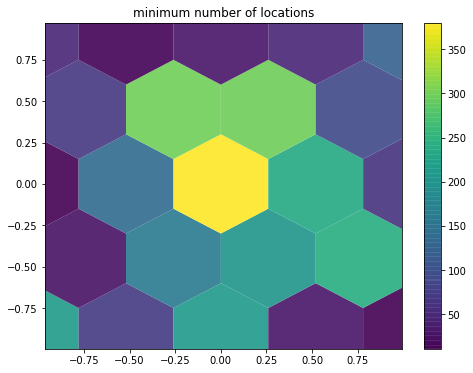

In [4]:

## plot the minimum number of locations required to determine whether there is a force or not
map_plot(analyses, label=(partition_label, model_label, bayes_factor_label), title='minimum number of locations', feature='min_n', figsize=figsize, show=True)

## get the minimum number of locations per cell as a DataFrame
min_n = analyses[partition_label][model_label][bayes_factor_label].data['min_n'].astype(int)

## let us make a new partition
# copy the existing partition of the locations into cells (spatial bins)
import copy
previous_partition = analyses[partition_label].data
new_partition = copy.copy(previous_partition)

# reuse the tessellation to determine the cell indices for the locations,
# using the same parameters (but 'knn') that we define as a function
# that takes a cell index and returns the corresponding minimum number of
# nearest locations (nearest to the cell center) AND maximum number, which
# we let undefined (None)
kwargs = previous_partition.param.get('partition', {})
kwargs['knn'] = lambda i: (min_n.loc[i].values[0], None)
new_partition.cell_index = new_partition.tessellation.cell_index(new_partition.locations, **kwargs)

# add the new partition to the analysis tree, as a direct child of the data root;
# this initiates a new branch
new_partition_label = partition_label + ' with overlap'
analyses[new_partition_label] = new_partition


Actual number of locations per cell:

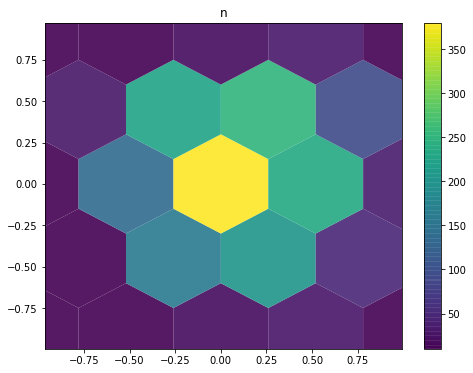

/home/flaurent/github/TRamWAy/tramway/inference/bayes_factors/group_by_sign.py:73: RuntimeWarning: invalid value encountered in greater_equal
  group_forces = 1 * (group_lg_B >= np.log10(B_threshold)) - \
/home/flaurent/github/TRamWAy/tramway/inference/bayes_factors/group_by_sign.py:74: RuntimeWarning: invalid value encountered in less_equal
  1 * (group_lg_B <= -np.log10(B_threshold))


In [5]:

## plot the actual number of locations per cell before we introduced 'knn'
map_plot(pd.DataFrame(previous_partition.location_count, columns=['n'], index=np.arange(previous_partition.number_of_cells)), cells=previous_partition, figsize=figsize, show=True)

## infer again;
# note that we use new_partition_label and consequently do not overwrite anything
infer(analyses, 'degraded.ddrift', sigma=localization_precision,
     input_label=new_partition_label, output_label=model_label)
infer(analyses, 'snr', input_label=(new_partition_label, model_label), inplace=True)
_=infer(analyses, 'bayes_factor', sigma=localization_precision,
     input_label=(new_partition_label, model_label), output_label=bayes_factor_label)


Estimated force after increasing n:

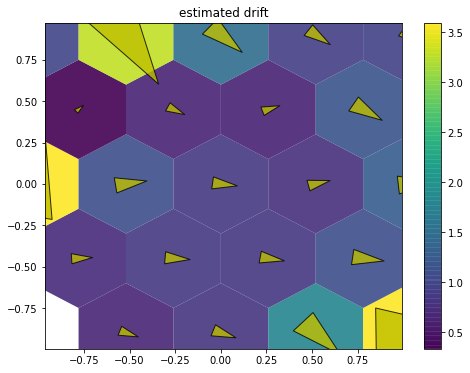

In [6]:

## plot the new force detection map
map_plot(analyses, label=(new_partition_label, model_label), title='estimated drift', feature='drift', cell_arrow_ratio=1, figsize=figsize, show=True)


Force presence:

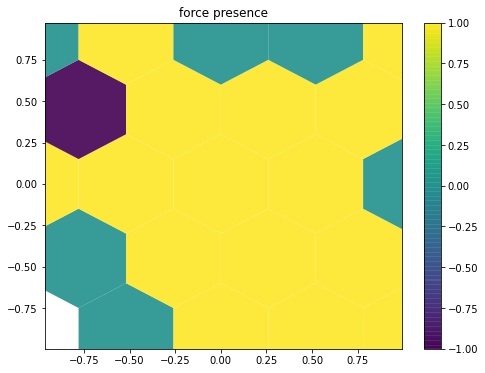

In [7]:

map_plot(analyses, label=(new_partition_label, model_label, bayes_factor_label), title='force presence', feature='force', figsize=figsize, show=True)



    1= force; 0= not enough evidence; -1= no force

Note that fewer results are undefined (fewer cells are 0);
not all the results are defined because the data variance has varied.